<p style="font-family: Arial; 
font-size:2em;
color:#2462C0; 
font-style:bold"
>NFLdb Example - Carson Wentz Stats</p>

#### Comparing Carson Wentz's QB Rating

In [1]:
import nfldb
import pandas as pd
import numpy as np

Connect to NFLdb.

In [2]:
db = nfldb.connect()

Define function that calculates NFL Passer Rating.

In [3]:
def nfl_pass_rating(pass_att,pass_cmp,pass_yds,pass_tds,pass_int):
    cmp_per_att = (pass_cmp/pass_att-0.3)*5
    yds_per_att = (pass_yds/pass_att-3.0)*.25
    td_per_att = (pass_tds/pass_att)*20
    int_per_att = 2.375 - (25*pass_int/pass_att)
    pass_rating = ((cmp_per_att+yds_per_att+td_per_att+int_per_att)/6)*100
    return pass_rating

Using nfldb 'Query' class, query db for QB stats needed for *nfl_pass_rating*. These stats include:
* Passing Attempts
* Passing Completions
* Passng Interceptions
* Total Passing Yards
* Total Passing Touchdowns

In [11]:
q = nfldb.Query(db)
q.game(season_year=2016, season_type='Regular',week=1)
q.player(position='QB')
q.play_player(passing_att__gt=0)
player_data = [(1, x.player.full_name, x.passing_att, x.passing_cmp, x.passing_yds, 
                x.passing_tds, x.passing_int) for x in q.as_aggregate()]

Pipe player stats ( of Python type *list* ) into a Pandas DataFrame. Get QB passer rating, add *pass_pct,* *pass_rtg,* and *week* features to dataframe, and sort by pass_rtg.

In [17]:
labels = ['week','full_name','pass_att','pass_cmp','pass_yds','pass_tds', 'pass_int']
df = pd.DataFrame.from_records(player_data,columns=labels)
df['pass_pct'] = 100*df.pass_cmp/df.pass_att
df['pass_rtg'] = nfl_pass_rating(df.pass_att,df.pass_cmp,df.pass_yds,df.pass_tds,df.pass_int) # calc rating
df.sort_values('pass_rtg',ascending=False).reset_index(drop=True).head(12) # show top 12 qb ratings for week 1

,week,full_name,pass_att,pass_cmp,pass_yds,pass_tds,pass_int,pass_pct,pass_rtg
0,1,Drew Brees,42,28,423,4,0,66.666667,131.349206
1,1,Matthew Stafford,39,31,340,3,0,79.487179,130.288462
2,1,Jameis Winston,33,23,281,4,1,69.696970,123.421717
3,1,Andrew Luck,47,31,385,4,0,65.957447,119.547872
4,1,Andy Dalton,30,23,366,1,1,76.666667,114.027778
5,1,Matt Ryan,39,27,334,2,0,69.230769,112.553419
6,1,Ben Roethlisberger,37,27,300,3,1,72.972973,112.443694
7,1,Eli Manning,28,19,207,3,1,67.857143,110.267857
8,1,Jimmy Garoppolo,33,24,264,1,0,72.727273,106.123737
9,1,Carson Palmer,37,24,271,2,0,64.864865,104.673423



Up to this point we've been able to extract QB passing stats for a single week. The dataframe above gives the top 12 QBs (by passer rating) for Week 1. Carson Wentz got Philly fans very excited after a Top 12 performance in the first game of his rookie year. Let's see how he stands against other QBs through the rest of the season. 

We'll have to modify the code slightly to aquire statistics for each week of the 2016 Regular Season.

In [26]:
weeks = np.arange(1,18)
season = {}
for wk in weeks:
    q = nfldb.Query(db)
    q.game(season_year=2016, season_type='Regular',week=wk)
    q.player(position='QB')
    q.play_player(passing_att__gt=0)
    season[wk] = [(wk, x.player.full_name,x.passing_att,x.passing_cmp,x.passing_yds, 
                    x.passing_tds,x.passing_int) for x in q.as_aggregate()]

Store dataframes for each week in dictionary called *season_df*. For each week, get QB passer rating, add pass_pct, pass_rtg, and week features to dataframe, and sort by pass_rtg.

In [33]:
season_dfs = {'Week '+str(wk): pd.DataFrame.from_records(season[wk],columns=labels) for wk in weeks}
for wk in weeks:
    df_tmp = season_dfs['Week '+str(wk)]
    df_tmp['pass_pct'] = 100*df_tmp.pass_cmp/df_tmp.pass_att
    df_tmp['pass_rtg'] = nfl_pass_rating(df_tmp.pass_att, df_tmp.pass_cmp,
                                            df_tmp.pass_yds, df_tmp.pass_tds, df_tmp.pass_int) # calc rating
    season_dfs['Week '+str(wk)] = df_tmp

# manually check for same output
# season_dfs['Week 1'].head() == df.head()
season_dfs['Week 1'].sort_values('pass_rtg',ascending=False).reset_index(drop=True).head(12)

,week,full_name,pass_att,pass_cmp,pass_yds,pass_tds,pass_int,pass_pct,pass_rtg
0,1,Drew Brees,42,28,423,4,0,66.666667,131.349206
1,1,Matthew Stafford,39,31,340,3,0,79.487179,130.288462
2,1,Jameis Winston,33,23,281,4,1,69.696970,123.421717
3,1,Andrew Luck,47,31,385,4,0,65.957447,119.547872
4,1,Andy Dalton,30,23,366,1,1,76.666667,114.027778
5,1,Matt Ryan,39,27,334,2,0,69.230769,112.553419
6,1,Ben Roethlisberger,37,27,300,3,1,72.972973,112.443694
7,1,Eli Manning,28,19,207,3,1,67.857143,110.267857
8,1,Jimmy Garoppolo,33,24,264,1,0,72.727273,106.123737
9,1,Carson Palmer,37,24,271,2,0,64.864865,104.673423


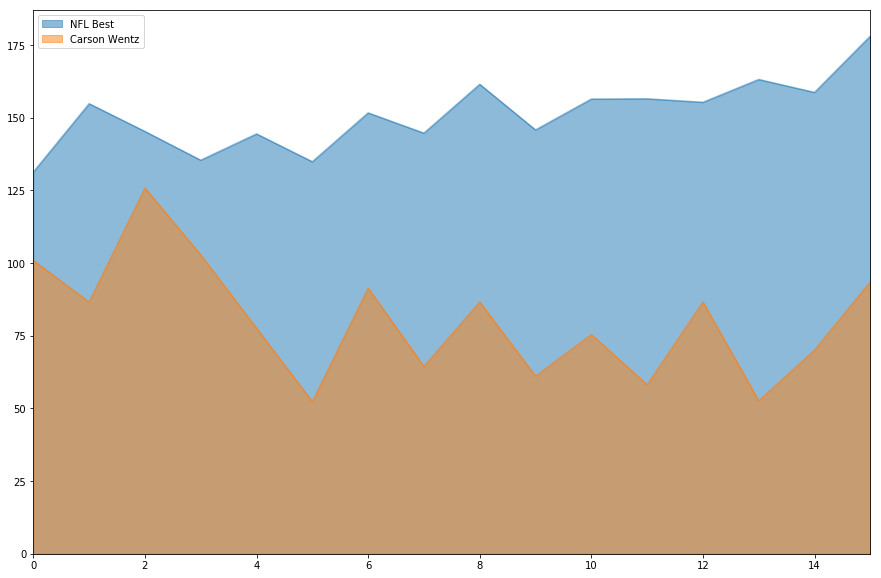

In [94]:
%matplotlib inline

bye = 4
max_rtg = [season_dfs['Week '+str(wk)]['pass_rtg'].max() for wk in weeks[weeks!=bye]]
wentz_rtg = [float(season_dfs['Week '+str(wk)][season_dfs['Week '+str(wk)]['full_name'] =='Carson Wentz']['pass_rtg'].values)
                for wk in weeks[weeks!=bye]]
new_df = pd.DataFrame([max_rtg, wentz_rtg]).T
new_df.columns = ['NFL Best','Carson Wentz']
new_df.plot.area(stacked=False,figsize=(15,10))